## Ejemplo red DCGAN usando TensorFLow


### Se recomienda ver primero el ejemplo de red clasificadora, pues muchas cosas básicas de TensorFlow se explican ahí. 

### Una DCGAN (Deep Convolutional Generative Adversarial Network) es un tipo de red generativa que se basa en la competencia entre dos modelos, el generador y el discriminador. El discriminador recibe elementos reales del dataset (en este caso imágenes) y elementos fabricados, y entrena para poder distinguir cuales son reales y cuales no. El generador, como dice su nombre, genera elementos nuevos, y entrena para lograr engañar al discriminador y hacer pasar sus elementos como elementos originales del dataset.


Iportante: No se recomienda correr esta red sin una GPU, pues es muy pesada.

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals


import tensorflow as tf
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from IPython import display

# Definimos un uso máximo de memoria de GPU
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
session = InteractiveSession(config=config)

In [2]:

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5 # Normalizamos las imagenes a [-1, 1]

In [3]:
# Buffer size determina que tan aleatorio sera nuestro dataset. Para lograr aleatoriedad
# perfecta se debe usar un buffer size mayor al numero de elementos en el dataset
BUFFER_SIZE = 60000


# El batch size determina de a cuantos elementos consecutivos agruparemos. 
# Es deseable que el numero de elementos totales sea divisible por el batch size
BATCH_SIZE = 256

# Agrupamos y aleatorizamos nuestro dataset.
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [4]:
#Esta función crea nuestro modelo generador.
# Genera imagenes a partir de un seed, dando valores numéricos al color de cada pixel. Comienza con una capa de
# input de tamaño BATCH_SIZE y genera un output de 7x7. Aumenta el tamaño de su output 
#hasta llegar al 28x28 deseado.

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256) 

#Transponemos la entrada de esta capa para generar un output de BATCH_SIZE/2
    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

#LLegamos a la forma deseada de nuestra imagen.
    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

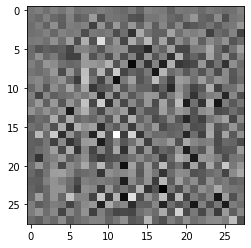

In [5]:
# Creamos nuestro generador y usamos un ejemplo de ruido aleatorio como primera imagen para el modelo discriminador
generator = make_generator_model()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [6]:
#Esta función crea nuestro modelo discriminador.

# Tiene una entrada con la forma de nuestras imágenes.
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                                     input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU()) # LeakyReLU es la función de activación usada en este modelo.
    model.add(layers.Dropout(0.3)) # Dropout convierte una fracción de los inputs recibidos en 0, con el objetivo
    # de evitar overfitting y generar instancias distintas de entrenamiento.
    
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [7]:
# Creamos nuestro discriminador y usamos la imagen aleatoria anterior para probarlo


discriminator = make_discriminator_model()
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00064793]], shape=(1, 1), dtype=float32)


In [8]:
# Esta es nuestra función de perdida
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Nuestro discriminador busca clasificar las entradas que recibe segun si son imágenes reales o no.
#Comparamos sus predicciones con 0 si son falsas y 1 si son verdaderas, y esta diferencia es lo que busca minimizar
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss


# Por el otro lado, todas las imágenes generadas son falsas, luego el generador busca que sus 
# imágenes sean clasificadas como verdaderas, por lo que minimizamos la diferencia entre la 
# clasificación de las imagenes y 1
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [9]:
# Creamos checkpoints para la red



checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [10]:
# Acá definiremos nuestro loop de entrenamiento, ademas de un seed que se usara para crear las imágenes.


EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16


seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [11]:

# El uso de tf.function nos deja compilar la función.
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [12]:

def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    # Guardamos imágenes para el GIF final
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    # Guardamos el modelo cada 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generamos una imagen para el epoch final
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [13]:
# Esta función genera las imagenes
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

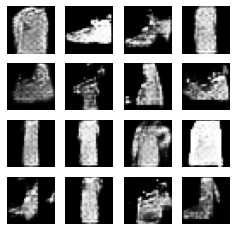

In [14]:
# Entrenamos nuestro modelo

train(train_dataset, EPOCHS)

In [15]:

#podemos cargar el ultimo checkpoint
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

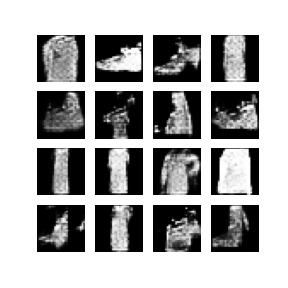

In [16]:

# Usaremos estos elementos generados para crear un gif con el progreso
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))



display_image(EPOCHS)

In [17]:
# Finalmente, creamos el gif

anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)




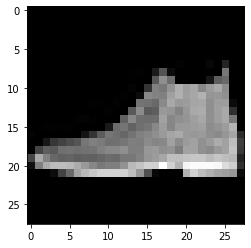

In [18]:
plt.imshow(test_images[0], cmap='gray')
plt.show()

![SegmentLocal](dcgan.gif "segment")